In [3]:
# !unzip /content/drive/MyDrive/Vehicle_dataset.zip -d /content

In [4]:
import math
import random
import numpy as np
import json
import cv2
import os
import torch
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
import torch
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def set_seed(seed_number:int=42, loader=None):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_number)

    np.random.seed(seed_number)

    random.seed(seed_number)

set_seed(42)

In [6]:
class CFG:

    train_batch_size = 4
    test_batch_size = 1

    lr = 0.0001
    lr_finetune = 0.0005
    weight_decay = 1e-4

    epochs = 16

cfg = CFG()

In [7]:
train_img_path = '/content/VehiclesDetection_FasterRCNN/data/Apply_Grayscale/Vehicles_Detection.v9i.coco/train'
train_label_file = '/content/VehiclesDetection_FasterRCNN/data/Apply_Grayscale/Vehicles_Detection.v9i.coco/train/_annotations.coco.json'

test_img_path = '/content/VehiclesDetection_FasterRCNN/data/Apply_Grayscale/Vehicles_Detection.v9i.coco/test'
test_label_file = '/content/VehiclesDetection_FasterRCNN/data/Apply_Grayscale/Vehicles_Detection.v9i.coco/test/_annotations.coco.json'

In [8]:
with open(train_label_file) as json_file:
    train_data_dict = json.load(json_file)

with open(test_label_file) as json_file:
    test_data_dict = json.load(json_file)

In [9]:
train_data_dict['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 2,
 'bbox': [235, 407, 38, 83],
 'area': 3154,
 'segmentation': [],
 'iscrowd': 0}

In [10]:
cat_mapping = dict() # Variable that maps class id -> class name

for category in train_data_dict['categories']:
    cat_mapping[category['id']] = category['name']

In [11]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bboxes):
        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, bboxes):
        if random.random() < self.p:
            image = F.hflip(image)
            width, _ = image.size
            if len(bboxes)!=0:
                bboxes = bboxes.clone()
                bboxes[:, [0, 2]] = width - bboxes[:, [2, 0]]
        return image, bboxes


class ToTensor(object):
    def __call__(self, image, bboxes):
        image = F.to_tensor(image)
        return image, bboxes

In [12]:
train_transform = Compose([
            RandomHorizontalFlip(p=0.5),
            ToTensor()
        ])

val_transform = Compose([
            ToTensor()
        ])

test_transform = val_transform

In [13]:
class VehicleDetectionDataset(Dataset):
    def __init__(self, img_path, data_dict, transform=None):
        self.img_path = img_path
        self.data_dict = data_dict
        self.transform = transform
        self.dataset = self.create_dataset()

    def create_dataset(self):
        dataset = []
        for element in self.data_dict["images"]:
            img_id = element['id']
            img_annotations = []
            for annotation in self.data_dict['annotations']:
                if annotation['image_id'] == img_id:
                    img_annotations.append(annotation)
            dataset.append([element['file_name'], img_annotations])

        return dataset

    def __len__(self):
        return len(self.data_dict['images'])

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()
        areas = list()
        image_id = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            areas.append(b[3])
            image_id.append(b[4])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, areas, image_id

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.img_path, self.dataset[idx][0]))

        cat_ids = []
        bbs = []
        areas = []
        iscrowd = []
        image_id = []
        for annotation in self.dataset[idx][1]:
            cat_ids.append(annotation['category_id'])
            bbs.append(annotation['bbox'])
            areas.append(annotation['area'])
            iscrowd.append(annotation['iscrowd'])
            image_id.append(annotation['image_id'])
        cat_ids = torch.Tensor(cat_ids)

        areas = torch.Tensor(areas)
        iscrowd = torch.Tensor(iscrowd)
        image_id = torch.Tensor(image_id)

        bbs = np.array(bbs)
        for i, bb in enumerate(bbs):
            x_min, y_min, width, height = bb
            x1, y1 = x_min, y_min
            x2, y2 = x_min + width, y_min + height
            bbs[i] = np.array([x1, y1, x2, y2])

        bbs = torch.Tensor(bbs)
        if self.transform:
            img = Image.fromarray(img)
            img, bbs = self.transform(img, bbs)

        bbs = torch.from_numpy(np.array(bbs))
        cat_ids = torch.Tensor(cat_ids).long()

        return img, bbs, cat_ids, areas, image_id

In [14]:
train_dataset = VehicleDetectionDataset(train_img_path, train_data_dict, transform=train_transform)
test_dataset = VehicleDetectionDataset(test_img_path, test_data_dict, transform=test_transform)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.test_batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

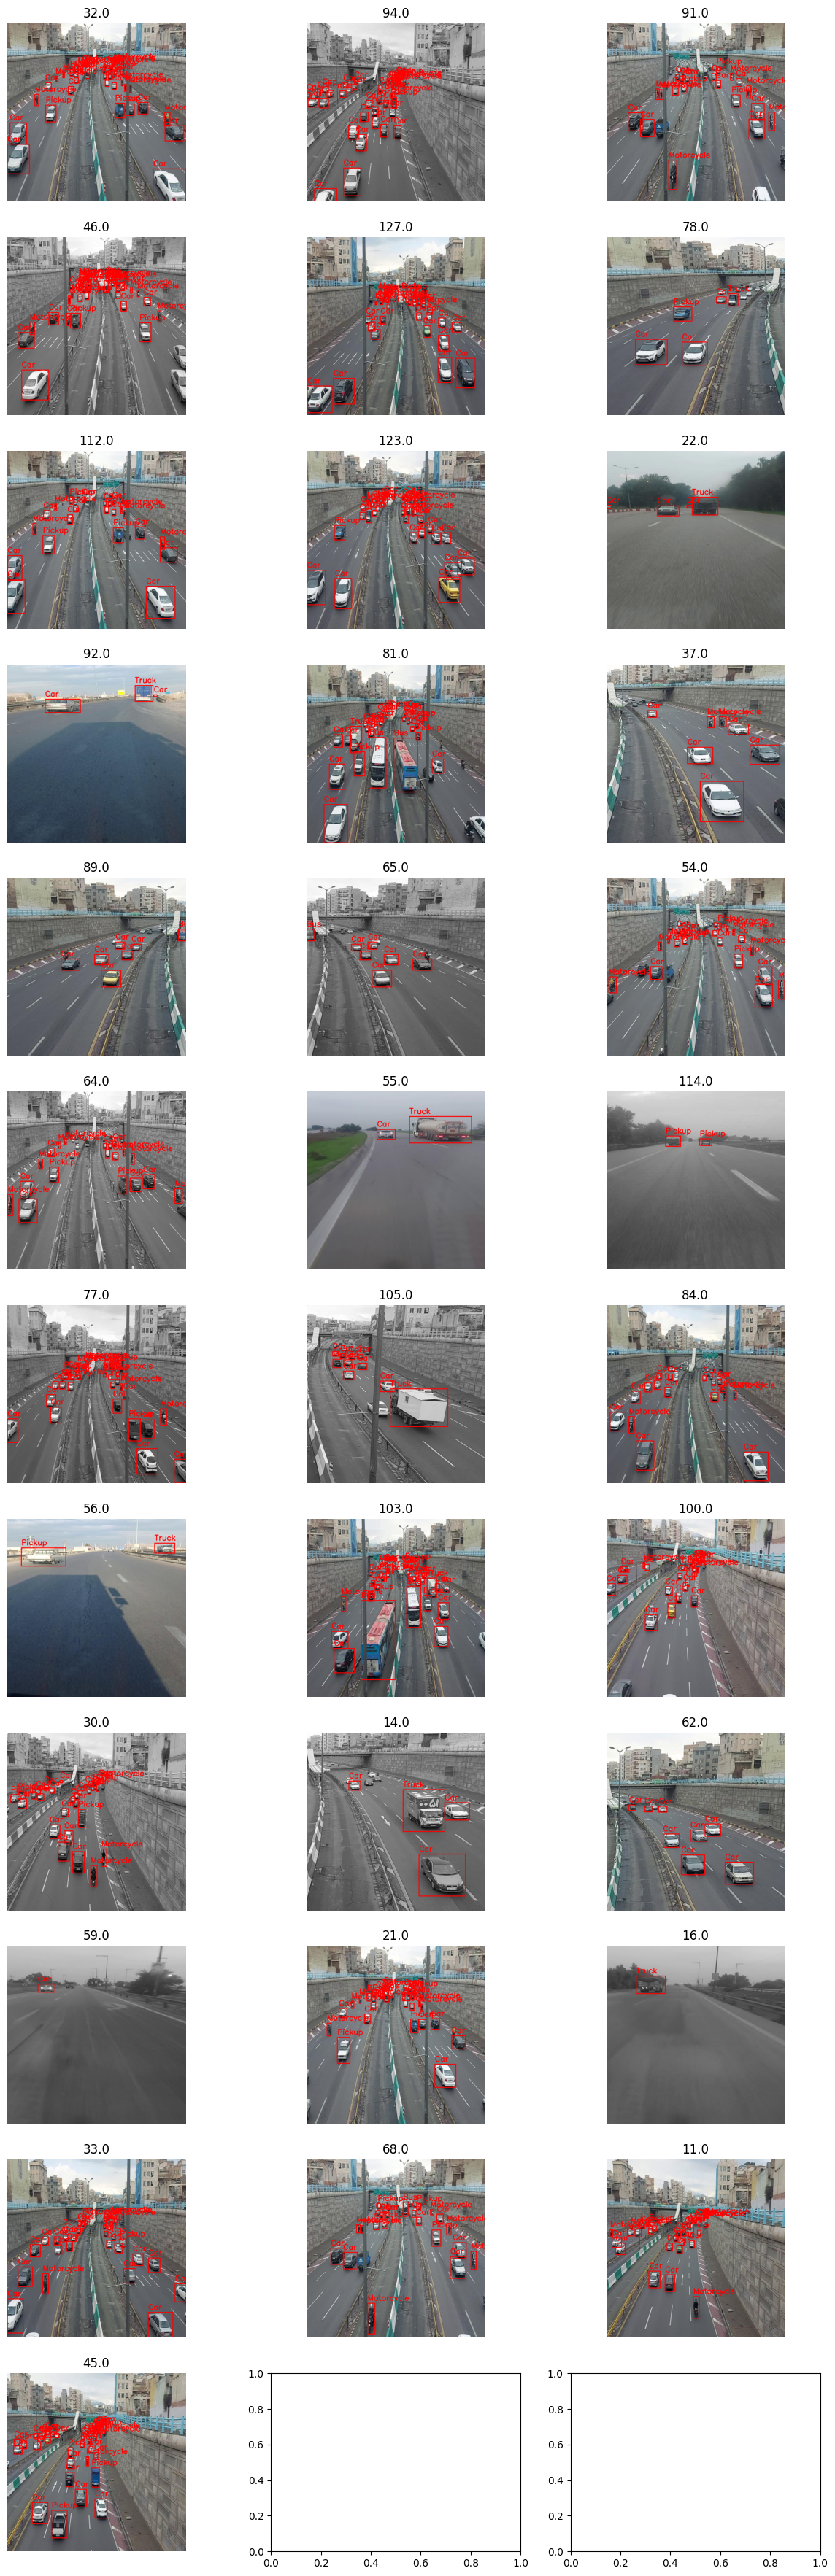

In [16]:
def plot_images_with_boxes(images, bbs, labels, image_id, class_names, ax, i, columns):
    for img, bb, lbl, img_id in zip(images, bbs, labels, image_id):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8) # Convert image from [0, 1] to [0, 255] range

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert from RGB (Matplotlib) to BGR (OpenCV)

        for box, label in zip(bb, lbl): # For each bounding box and label found in the image
            x1, y1, x2, y2 = map(int, box) # Convert Tensor values in box to integers
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)  # Draw bounding box
            cv2.putText(img, class_names[int(label)], org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=(255, 0, 0), thickness=2)  # Draw class label

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for plotting
        ax[i//columns][i%columns].imshow(img)
        ax[i//columns][i%columns].axis("off")
        ax[i//columns][i%columns].set_title(f"{img_id[0]}")
        break

rows = math.ceil(len(train_dataloader)/3)
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 45))
for i, (images, bbs, labels, areas, image_id) in enumerate(train_dataloader):
    plot_images_with_boxes(images, bbs, labels, image_id, cat_mapping, ax, i, columns)
plt.show()

In [17]:
class_frequencies = {cat_mapping[k]:0 for k,v in cat_mapping.items()}

for annotation in train_data_dict['annotations']:
    category_id = annotation['category_id']
    category_name = cat_mapping[category_id]
    class_frequencies[category_name] = class_frequencies[category_name] + 1

In [18]:
classes = list(class_frequencies.keys())
frequencies = list(class_frequencies.values())

fig = go.Figure(data=[go.Bar(x=classes, y=frequencies)])
fig.update_layout(
    title='Class Frequency Histogram',
    xaxis_title='Class Names',
    yaxis_title='Frequency',
    template='seaborn'
)

fig.show()

In [31]:
def get_resnet50_backbone(pretrained=True):
    resnet = resnet50(weights='IMAGENET1K_V2' if pretrained else None)

    backbone = nn.Sequential(
        resnet.conv1,
        resnet.bn1,
        resnet.relu,
        resnet.maxpool,
        resnet.layer1,
        resnet.layer2,
        resnet.layer3
    )

    backbone.out_channels = 1024
    return backbone

def get_fasterrcnn_model(num_classes, pretrained=False):
    backbone = get_resnet50_backbone(pretrained=pretrained)

    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=rpn_anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_min_x = max(x1_min, x2_min)
    inter_min_y = max(y1_min, y2_min)
    inter_max_x = min(x1_max, x2_max)
    inter_max_y = min(y1_max, y2_max)

    inter_area = max(0, inter_max_x - inter_min_x) * max(0, inter_max_y - inter_min_y)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def plot_test_predictions(image, boxes, labels, scores, class_names, true_boxes, true_labels, image_id, iou_threshold=0.7):
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, box)
        match = False
        match_bb = False
        for true_box, true_label in zip(true_boxes, true_labels):
            if calculate_iou(box, true_box) >= iou_threshold and label == true_label: # Bounding Box and class right
                match = True
            elif calculate_iou(box, true_box) >= iou_threshold: # Bounding Box right but class wrong
                match_bb = True

        text = f'{class_names[int(label)]}: {score:.2f}'
        if match:
            green = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=green, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=green, thickness=2)
        elif match_bb:
            blue = (0, 0, 255)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=blue, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=blue, thickness=2)
        else:
            red = (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=red, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=red, thickness=2)

    plt.title(f'Image {int(image_id[0])}')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [32]:
class LossLogger:
    def __init__(self):
        self.classifier_loss = 0
        self.box_loss = 0
        self.objectiveness_loss = 0
        self.rpn_box_loss = 0
        self.total_loss = 0
        self.count = 0

    def log(self, loss_dict):
        self.classifier_loss += loss_dict['loss_classifier'].detach().tolist()
        self.box_loss += loss_dict['loss_box_reg'].detach().tolist()
        self.objectiveness_loss += loss_dict['loss_objectness'].detach().tolist()
        self.rpn_box_loss += loss_dict['loss_rpn_box_reg'].detach().tolist()
        self.total_loss += sum(loss for loss in loss_dict.values()).detach().tolist()
        self.count += 1

    def reset(self):
        self.classifier_loss = 0
        self.box_loss = 0
        self.objectiveness_loss = 0
        self.rpn_box_loss = 0
        self.total_loss = 0
        self.count = 0

    def get(self):
        self.classifier_loss = self.classifier_loss / self.count
        self.box_loss = self.box_loss / self.count
        self.objectiveness_loss = self.objectiveness_loss / self.count
        self.rpn_box_loss = self.rpn_box_loss / self.count
        self.total_loss = self.total_loss / self.count
        losses = {
            'Classifier Loss' : self.classifier_loss,
            'Box Loss' : self.box_loss,
            'Objectiveness Loss' : self.objectiveness_loss,
            'RPN Box Loss' : self.rpn_box_loss,
            'Total Loss' : self.total_loss
        }
        return losses

In [22]:
def get_report(epoch, logger, train = True):
    loop = 'Train' if train else 'Validation'
    print(f'Epoch {epoch} :')
    print(f'{loop} Losses :')
    loss = logger.get()
    for k,v in loss.items():
        print(f'{k} : {v}')
    print('\n\n')

In [23]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, epoch, logger):
    model.train()
    logger.reset()
    i = 0
    total_train_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    total_samples = 0
    for images, bbs, labels, areas, image_id in dataloader:
        images = images.float().to(device)
        targets = [{'boxes':bbs[i].to(device), 'labels':labels[i].to(device)} for i, bb in enumerate(bbs)]

        optimizer.zero_grad()

        if 0 in list(map(len, bbs)):
            continue

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        logger.log(loss_dict)

        total_train_loss += losses.item() * images.size(0)
        loss_classifier += loss_dict['loss_classifier'].item() * images.size(0)
        loss_box_reg += loss_dict['loss_box_reg'].item() * images.size(0)
        loss_objectness += loss_dict['loss_objectness'].item() * images.size(0)
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() * images.size(0)
        total_samples += images.size(0)
        i += 1

    average_train_loss = total_train_loss / total_samples
    average_classifier_loss = loss_classifier / total_samples
    average_box_reg_loss = loss_box_reg / total_samples
    average_objectness_loss = loss_objectness / total_samples
    average_rpn_box_reg_loss = loss_rpn_box_reg / total_samples
    lr_scheduler.step()

    print(f"Epoch {epoch + 1}, Total Loss: {average_train_loss:.4f}, Class. Loss: {average_classifier_loss:.4f}, Box Reg. Loss: {average_box_reg_loss:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.7f}", end='\r')

    return average_train_loss, average_classifier_loss, average_box_reg_loss

In [46]:
num_classes = len(cat_mapping.keys())
pretrained_model = get_fasterrcnn_model(num_classes, pretrained=True).to(device)
logger = LossLogger()

In [47]:
params = [p for p in pretrained_model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=cfg.lr_finetune, weight_decay=cfg.weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.epochs//2, gamma=0.1)

In [48]:
pretrained_model.train()
train_losses = []
for epoch in range(cfg.epochs):
    epc_train_loss, epc_class_loss, epc_box_reg_loss = train_epoch(pretrained_model, train_dataloader, optimizer, lr_scheduler, epoch, logger)
    train_losses.append(epc_train_loss)
    get_report(epoch, logger, train = True)

epochs = range(1, len(train_losses) + 1)

Epoch 0 :
Train Losses :
Classifier Loss : 0.6467589507810771
Box Loss : 0.30338804982602596
Objectiveness Loss : 0.19010152644477785
RPN Box Loss : 0.12604508397635072
Total Loss : 1.2662936188280582



Epoch 1 :
Train Losses :
Classifier Loss : 0.35408304992950324
Box Loss : 0.3812936372829206
Objectiveness Loss : 0.08258267842007405
RPN Box Loss : 0.06525220177277472
Total Loss : 0.8832115666432814



Epoch 2 :
Train Losses :
Classifier Loss : 0.28667351603507996
Box Loss : 0.33972297655418515
Objectiveness Loss : 0.045812771597411484
RPN Box Loss : 0.056687717529712245
Total Loss : 0.7288969783112407



Epoch 3 :
Train Losses :
Classifier Loss : 0.24580602394416928
Box Loss : 0.31764746038243175
Objectiveness Loss : 0.034011289331829175
RPN Box Loss : 0.04873973969370127
Total Loss : 0.6462045162916183



Epoch 4 :
Train Losses :
Classifier Loss : 0.2037745958659798
Box Loss : 0.2826607492752373
Objectiveness Loss : 0.026225536596029997
RPN Box Loss : 0.03989960011676885
Total Loss

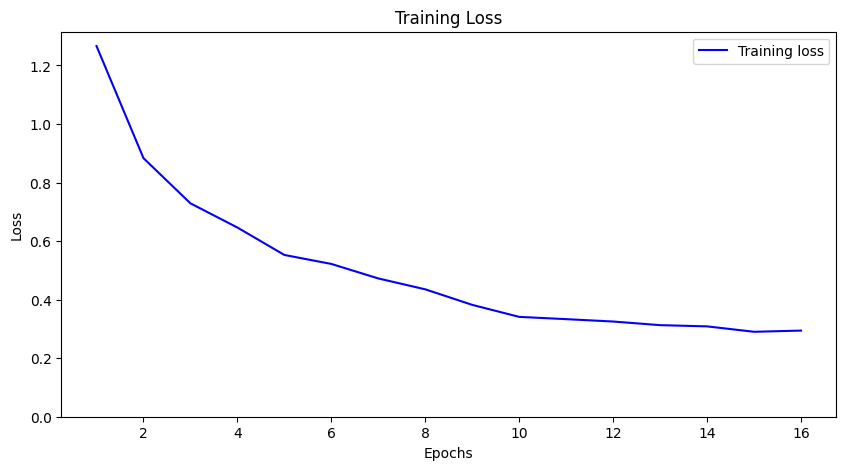

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0)
plt.show()

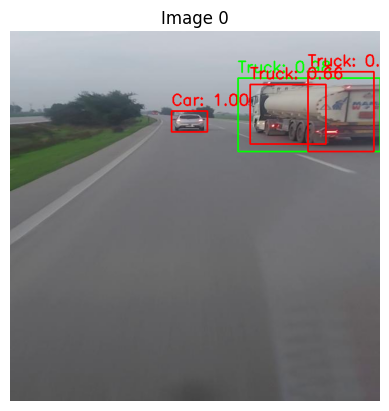

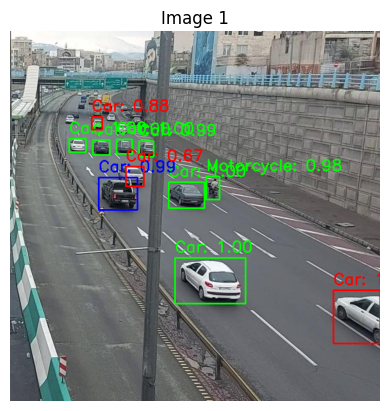

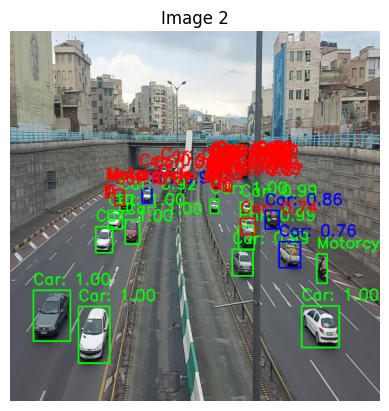

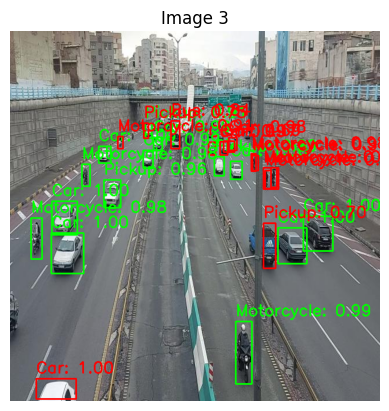

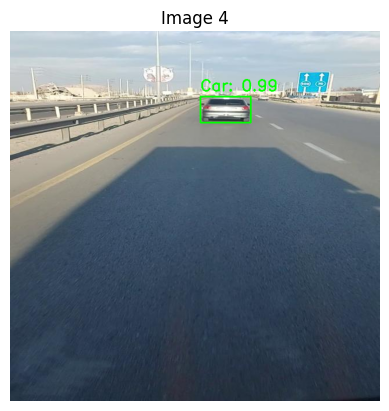

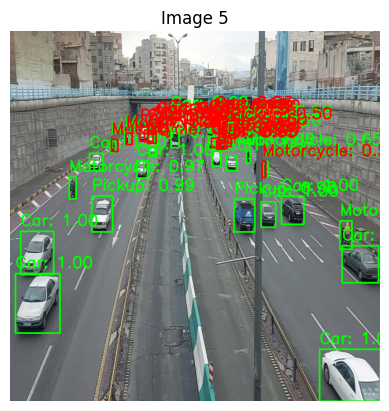

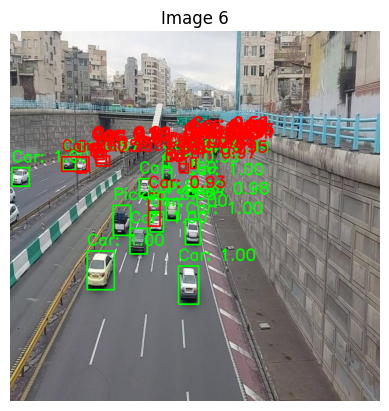

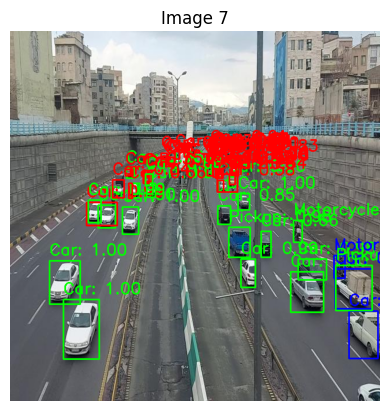

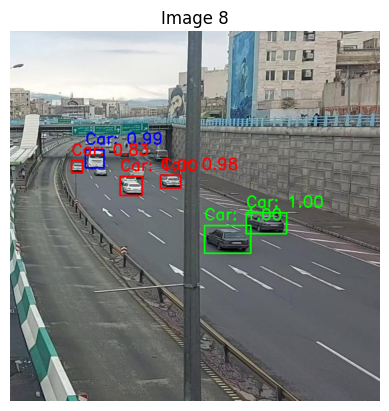

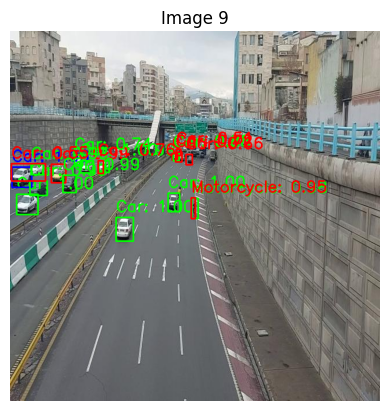

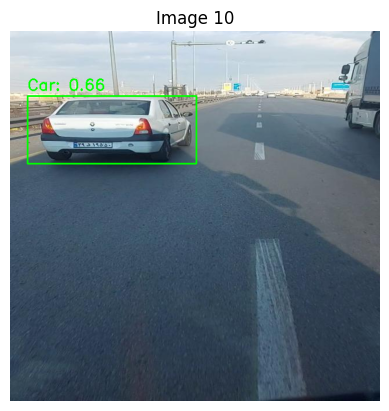

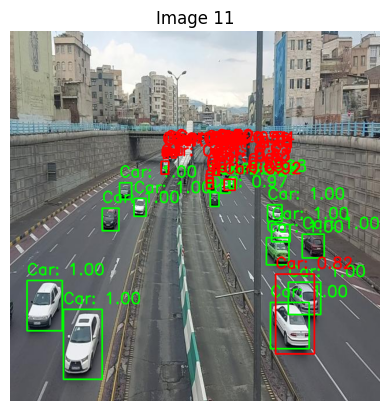

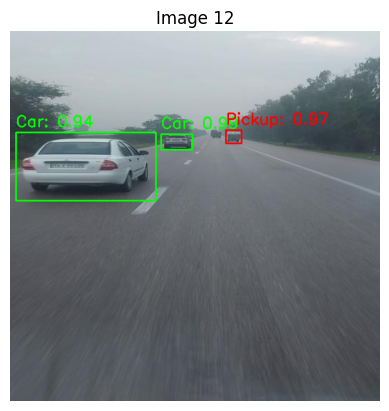

In [50]:
pretrained_model.eval()
for images, bbs, labels, areas, image_id in test_dataloader:
    images = images.float().to(device)

    with torch.no_grad():
        prediction = pretrained_model(images)

    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    true_boxes = bbs[0].numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()
    true_labels = labels[0].numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_boxes = pred_boxes[pred_scores >= 0.5].tolist()
    pred_labels = pred_labels[pred_scores >= 0.5].tolist()
    pred_scores = pred_scores[pred_scores >= 0.5].tolist()

    images = images.cpu().detach()

    plot_test_predictions(images[0], pred_boxes, pred_labels, pred_scores, cat_mapping, true_boxes, true_labels, image_id[0])

In [ ]:
torch.save(pretrained_model.state_dict(), 'VehicleFasterRcnnModel.pth')

In [ ]:
loaded_model = get_fasterrcnn_model(num_classes, pretrained=True).to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('VehicleFasterRcnnModel.pth'))